# Quora Insincere Questions Classification - Part 2
This notebook addresses the Quora Insincere Questions Classification Kaggle competition (https://www.kaggle.com/c/quora-insincere-questions-classification). In this version a LSTM based classifier is used to detect insincere question submissions. We will also use pretrained embeddings instead of learning them from the training data. As F1 score is the metric used to rank submissions in the competition, it is this metric that the classifier will be optimised for. 

Firstly, we'll load the necessary libraries and read the csv files into dataframes:

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, ParameterGrid
import matplotlib
from matplotlib import pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

import os
print(os.listdir("../input"))

#print embedding file names
print(os.listdir("../input/embeddings/glove.840B.300d"))


['embeddings', 'train.csv', 'sample_submission.csv', 'test.csv']
['glove.840B.300d.txt']


Using TensorFlow backend.


Load in the training and test files:


In [2]:
#Load in the training and test sets
trainset = pd.read_csv('../input/train.csv')
testset = pd.read_csv('../input/test.csv')

#Inspect that everything looks as it should:
print(trainset.head())
print(trainset.columns)
print(trainset.shape)

#Check how balanced the training set is
print(trainset['target'].value_counts())


                    qid  ...   target
0  00002165364db923c7e6  ...        0
1  000032939017120e6e44  ...        0
2  0000412ca6e4628ce2cf  ...        0
3  000042bf85aa498cd78e  ...        0
4  0000455dfa3e01eae3af  ...        0

[5 rows x 3 columns]
Index(['qid', 'question_text', 'target'], dtype='object')
(1306122, 3)
0    1225312
1      80810
Name: target, dtype: int64


Note there are around 15 'sincere' tagged questions for every sincere question, making the dataset somewhat unbalanced, depending on the algorithm used, it may be necessary to take this imbalance into account. 

Next clean the question strings

EDIT: cleaning actually resulted in significantly worse performance than using the uncleaned text - It is likely such nuances are significant when determining question sincerity. It is likely that a subset of the cleaning steps tried would result in an improvement, but that has not been attempted here. The text cleaning function is left in to show what was attempted, but it was not used in the final result:

In [3]:
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
def clean_text(text):
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    ## Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return(text)

# apply the above function to the train and test sets
#EDIT - DID NOT USE - cleaned text is simply set to original question text
trainset['cleaned_text'] = trainset['question_text']
testset['cleaned_text'] = testset['question_text']
#trainset['cleaned_text'] = trainset['question_text'].map(lambda x: clean_text(x))
#testset['cleaned_text'] = testset['question_text'].map(lambda x: clean_text(x))

Inspect the cleaned text:

In [4]:
print(trainset[['question_text', 'cleaned_text']][0:3])
print(testset[['question_text', 'cleaned_text']][0:3])

                                       question_text                                       cleaned_text
0  How did Quebec nationalists see their province...  How did Quebec nationalists see their province...
1  Do you have an adopted dog, how would you enco...  Do you have an adopted dog, how would you enco...
2  Why does velocity affect time? Does velocity a...  Why does velocity affect time? Does velocity a...
                                       question_text                                       cleaned_text
0  My voice range is A2-C5. My chest voice goes u...  My voice range is A2-C5. My chest voice goes u...
1           How much does a tutor earn in Bangalore?           How much does a tutor earn in Bangalore?
2  What are the best made pocket knives under $20...  What are the best made pocket knives under $20...


Split the training data into training and validation sets. The test set is already provided as a separate file:

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(trainset[['qid','question_text','cleaned_text']], 
                                                  trainset['target'], test_size=0.15)
                                                        
#Check sizes
print('X_train, X_val, y_train, y_val')
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)




X_train, X_val, y_train, y_val
(1110203, 3) (195919, 3) (1110203,) (195919,)


Determine average and maximum lengths of cleaned questions. 
This will guide the sequence length selection later:

In [6]:
trainset['length']=[len(s.split()) for s in trainset['cleaned_text']]
testset['length']=[len(s.split()) for s in testset['cleaned_text']]

print('Trainset Average Words:', trainset['length'].mean())
print('Testset Average Words:', testset['length'].mean())

print('Trainset Max Words:', trainset['length'].max())
print('Testset Max Words:', testset['length'].max())


Trainset Average Words: 12.803609463740754
Testset Average Words: 12.75258116019159
Trainset Max Words: 134
Testset Max Words: 87


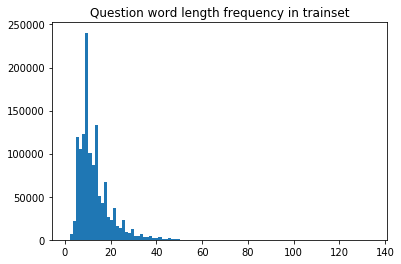

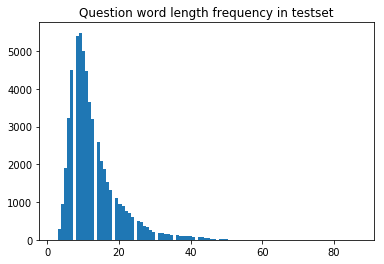

In [7]:

%matplotlib inline
plt.hist(trainset['length'], bins=100)
plt.title('Question word length frequency in trainset')
plt.show()
plt.hist(testset['length'], bins=100)
plt.title('Question word length frequency in testset')
plt.show()

A length of 87 words will cover all the testing data. Note if general performance were critical, rather just performance on this testset, a longer sequence length may be advantageous.

In [8]:
# Train tokenizer on training data
vocabulary_size = 50000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(X_train['cleaned_text'])

#Transform training and validation and test datasets to sequences.
train_sequence = tokenizer.texts_to_sequences(X_train['cleaned_text'])
LSTM_train_data = pad_sequences(train_sequence, maxlen=87)

val_sequence = tokenizer.texts_to_sequences(X_val['cleaned_text'])
LSTM_val_data = pad_sequences(val_sequence, maxlen=87)

test_sequence = tokenizer.texts_to_sequences(testset['cleaned_text'])
LSTM_test_data = pad_sequences(test_sequence, maxlen=87)



F1 score needs to be defined as a function before Keras can use it as a metric:

In [9]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [10]:
embeddings_index = dict()
f = open('../input/embeddings/glove.840B.300d/glove.840B.300d.txt')
for line in f:
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))


Loaded 2196016 word vectors.


In [11]:
vocabulary_size = 50000
embedding_matrix = np.zeros((vocabulary_size, 300))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector


The following block was used for hyperparameter optimization. It is commented out now so as to not slow down the kernel submission time. 

def build_LSTM(LSTM_size, dropout, emb_dims, lr, lr_decay):
    
    ## Network architecture
    model = Sequential()
    model.add(Embedding(50000, emb_dims, input_length=90))
    model.add(LSTM(LSTM_size, dropout=dropout))
    model.add(Dense(1, activation='sigmoid'))
    
    adam = optimizers.Adam(lr=lr, decay=lr_decay, beta_1=0.9, beta_2=0.999)
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1])
    return model
    
model = KerasClassifier(build_fn=build_LSTM)

grid = [{'LSTM_size':[100],'dropout':[0.1,0.5,0.9], 'lr':[0.01], 'lr_decay':[1e-6], 'epochs':[10], 
         'emb_dims':[300], 'batch_size':[10000]}]

best_score=0
score_grid = []

for g in ParameterGrid(grid):
    #Train model for given set of parameters
    model.set_params(**g)
    history = model.fit(LSTM_train_data,y_train, validation_split=0.2)
    
    #plot val_loss:
    plt.plot(range(1,len(history.history['val_f1'])+1),history.history['val_f1'], label=str(g['dropout'])+'val f1')
    #plt.plot(range(1,len(history.history['f1'])+1),history.history['f1'], label=str(g['LSTM_size'])+'f1')
    
    #Calculate f1 score
    preds = model.predict(LSTM_val_data)
    f1_s = f1_score(y_val, preds)
    
    score_grid.append([g, f1_s])
    
    # save if best
    if f1_s > best_score:
        best_score = f1_s
        best_grid = g
        
print('Best F1 score = ', best_score) 
print ('Best parameters = ',best_grid)
plt.legend(loc='best')
plt.show()
   

print(score_grid)

In [12]:
## Build the model
model = Sequential()
model.add(Embedding(50000, 300, weights=[embedding_matrix], input_length=87, trainable=False))
model.add(LSTM(80, dropout=0.8))
model.add(Dense(20, activation ='relu'))
model.add(Dense(1, activation='sigmoid'))

adam = optimizers.Adam(lr=0.001, decay=0, beta_1=0.9, beta_2=0.999)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 87, 300)           15000000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 80)                121920    
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1620      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 15,123,561
Trainable params: 123,561
Non-trainable params: 15,000,000
_________________________________________________________________


Train on 999182 samples, validate on 111021 samples
Epoch 1/40
999182/999182 [==============================] - 151s 151us/step - loss: 0.2493 - acc: 0.9298 - f1: 0.0132 - val_loss: 0.1648 - val_acc: 0.9407 - val_f1: 0.0676
Epoch 2/40
999182/999182 [==============================] - 147s 147us/step - loss: 0.1532 - acc: 0.9413 - f1: 0.2474 - val_loss: 0.1372 - val_acc: 0.9486 - val_f1: 0.4541
Epoch 3/40
999182/999182 [==============================] - 147s 147us/step - loss: 0.1421 - acc: 0.9453 - f1: 0.4294 - val_loss: 0.1348 - val_acc: 0.9502 - val_f1: 0.4489
Epoch 4/40
999182/999182 [==============================] - 147s 148us/step - loss: 0.1363 - acc: 0.9477 - f1: 0.4679 - val_loss: 0.1278 - val_acc: 0.9512 - val_f1: 0.4765
Epoch 5/40
999182/999182 [==============================] - 147s 147us/step - loss: 0.1329 - acc: 0.9487 - f1: 0.4779 - val_loss: 0.1277 - val_acc: 0.9521 - val_f1: 0.5025
Epoch 6/40
999182/999182 [==============================] - 147s 148us/step - loss: 0.13

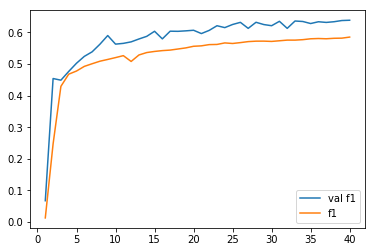

In [13]:
## Fit the model
history = model.fit(LSTM_train_data, y_train, validation_split=0.1,
                    batch_size=12000, epochs=40)

#plot the f1 score for both the validation and training sets:

plt.plot(range(1,len(history.history['val_f1'])+1),history.history['val_f1'], label='val f1')
plt.plot(range(1,len(history.history['f1'])+1),history.history['f1'], label='f1')

plt.legend(loc='best')
plt.show()

We can see that the validation F1 score has flattened off, while the training score is continuing to improve. Further training is only likely to lead to overfitting.

Now the model is trained, the prediction threshold that provides the optimal F1-score is found by testing the validation F1-score at regular intervals between 0.01 and 0.99.

The best threshold was  0.47999999999999976 with a maximum F1 score of  0.6479455868899408


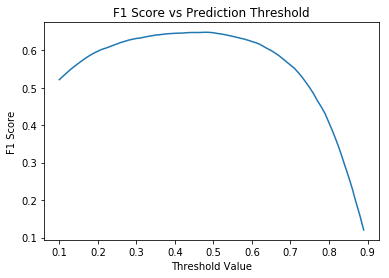

In [14]:
from sklearn.metrics import f1_score
#Get the F1 score for each threshold in the range 0.1 to 0.9:
f1_scores = []
maxf1 = 0 

for thresh in np.arange(0.1, 0.9, 0.01):
    probs = model.predict(LSTM_val_data, batch_size=30000)
    preds = [1 if probs[a] > thresh else 0 for a in range(len(probs))]
    f1score = f1_score(y_val, preds)
    f1_scores.append(f1score)
    if f1score > maxf1: 
        maxf1 = f1score 
        best_thresh = thresh

print('The best threshold was ', best_thresh, 'with a maximum F1 score of ', maxf1)

#Plot F1 score vs threshold value
plt.plot(np.arange(0.1, 0.9, 0.01),f1_scores, label='F1 score by threshold')
plt.ylabel('F1 Score')
plt.xlabel('Threshold Value')
plt.title('F1 Score vs Prediction Threshold')
plt.show()

Finally, predictions are made on the test set using the optimal prediction threshold and output to a datafile for submission.

In [15]:
#Get testset probabilities
test_probs = model.predict(LSTM_test_data, batch_size=10000)

#Convert testset probabilities to predictions using the optimal threshold
test_preds = [1 if test_probs[a] > best_thresh else 0 for a in range(len(test_probs))]

#Put predictions into the appropriate format for submission
submission_table = pd.DataFrame(test_preds, testset['qid'])
submission_table.columns=['prediction']
submission_table.to_csv('submission.csv')


## Summary
An LSTM network was successfully trained to distinguish between sincere and insincere questions. The performance was significantly improved over the Naive-Bayes model used in part I, as evidenced by the F1-score of 0.65 on both the validation set and kaggle's test set.
